# 3. Pregunta de Investigación 3: Clustering de Estilos de Juego

**Pregunta:** ¿Podemos agrupar los partidos en diferentes "estilos de juego" basándonos en la cantidad de goles y tiros?

Utilizaremos **K-Means Clustering** (Aprendizaje No Supervisado) para descubrir si los partidos se agrupan naturalmente en categorías distinguibles.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Cargar dataset
df = pd.read_csv('../data/cleaned_dataset.csv')

## 1. Selección y Preparación de Variables

Para definir el "estilo", usaremos dos variables compuestas que resumen la acción del partido:
1.  **Goles Totales:** Intensidad de anotación (`FTHG` + `FTAG`).
2.  **Tiros Totales:** Intensidad ofensiva o ritmo (`HS` + `AS`).

In [74]:
# Crear variables compuestas
df['TotalGoals'] = df['FTHG'] + df['FTAG']
df['TotalShots'] = df['HS'] + df['AS']

# Seleccionar solo estas dos para el modelo
X = df[['TotalGoals', 'TotalShots']]

print(X.head())

   TotalGoals  TotalShots
0           4          25
1           6          29
2           4          22
3           4          19
4           2          29


In [75]:
# Calcular correlación de Pearson
correlacion = df[['TotalGoals', 'TotalShots']].corr().iloc[0, 1]
print(f"Correlación de Pearson entre Tiros Totales y Goles Totales: {correlacion:.4f}")

if(correlacion>=0.4 and correlacion<=0.7):
    print("La correlación es moderada, se puede aplicar K-means")
elif(correlacion>0.7):    
    print("Correlacion alta, no conviene aplicar K-means.")
else:
    print("correlacion menor que 0.4 , ideal para K-means, ambas variables aportan información diferente.")


Correlación de Pearson entre Tiros Totales y Goles Totales: 0.2078
correlacion menor que 0.4 , ideal para K-means, ambas variables aportan información diferente.


## 2. Estandarización y Método del Codo

Es crucial escalar las variables para que tengan el mismo peso. Luego, probaremos con k=1 hasta k=10 clusters para encontrar el "codo" óptimo, que nos indicará el número natural de grupos.

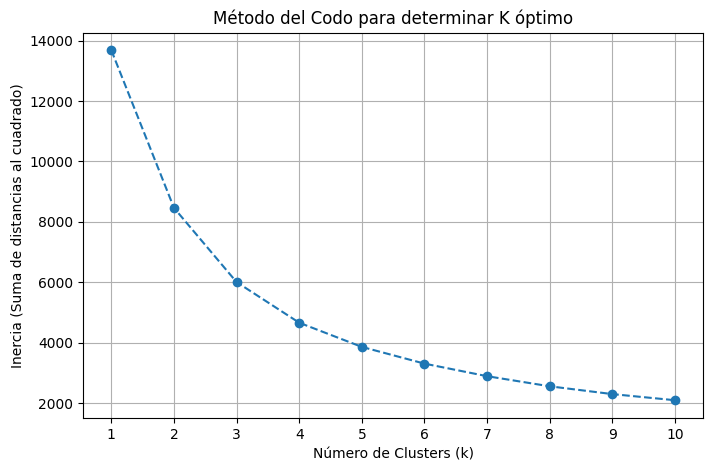

In [76]:
# 1. Estandarización (Z-Score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# 2. Método del Codo
inercias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inercias.append(kmeans.inertia_)

# Graficar la curva del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inercias, marker='o', linestyle='--')
plt.title('Método del Codo para determinar K óptimo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Suma de distancias al cuadrado)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## 3. Entrenamiento y Visualización de Clusters (K=3)

Basándonos en el gráfico anterior, seleccionamos **K=3** grupos. Entrenamos el modelo final y visualizamos cómo agrupa los partidos.

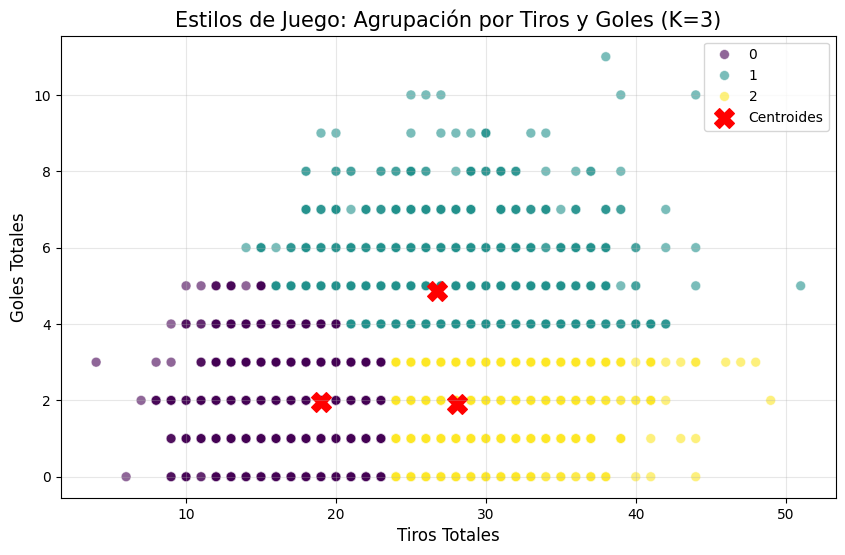

--- Perfiles de los Estilos de Juego ---
         TotalShots  TotalGoals
Cluster                        
0         18.973078    1.955367
1         26.737618    4.867925
2         28.085308    1.897027


In [77]:
# Entrenar K-Means con k=3
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Asignar los clusters al DataFrame original
df['Cluster'] = clusters

# Visualizar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalShots', y='TotalGoals', hue='Cluster', data=df, palette='viridis', alpha=0.6, s=50)

# Marcar los centroides (des-escalados para que coincidan con los ejes reales)
centroids = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=200, marker='X', label='Centroides')

plt.title('Estilos de Juego: Agrupación por Tiros y Goles (K=3)', fontsize=15)
plt.xlabel('Tiros Totales', fontsize=12)
plt.ylabel('Goles Totales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Ver características de cada grupo
print("--- Perfiles de los Estilos de Juego ---")
perfil = df.groupby('Cluster')[['TotalShots', 'TotalGoals']].mean()
print(perfil)

## 4. Interpretación y Conclusiones

Basándonos en los perfiles promedio obtenidos, asignaremos nombres descriptivos a cada grupo:

*   **Cluster 0:** Pocos Tiros (~19) y Pocos Goles (~2) $\rightarrow$ **Estilo Defensivo**.
*   **Cluster 1:** Muchos Tiros (~27) y Muchos Goles (~5) $\rightarrow$ **Estilo Ofensivo**.
*   **Cluster 2:** Muchos Tiros (~28) pero Pocos Goles (~2) $\rightarrow$ **Poco Acertados**.

Visualizaremos la proporción de cada estilo en la Premier League.

C:\Users\ronal\AppData\Local\Temp\ipykernel_14700\2681851984.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conteo_estilos.index, y=conteo_estilos.values, palette=['gray', 'red', 'orange'])


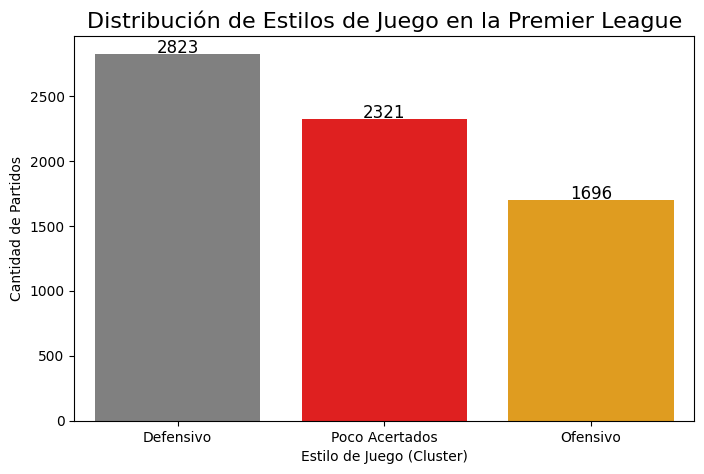

El estilo más común es: Defensivo (2823 partidos)


In [78]:
# Crear un mapeo de nombres
nombres_cluster = {
    0: 'Defensivo',
    1: 'Ofensivo',
    2: 'Poco Acertados'
}

# Aplicar el mapeo
df['Estilo_Juego'] = df['Cluster'].map(nombres_cluster)

# Contar cuántos partidos hay de cada tipo
conteo_estilos = df['Estilo_Juego'].value_counts()

# Gráfico de Barras Final
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=conteo_estilos.index, y=conteo_estilos.values, palette=['gray', 'red', 'orange'])

plt.title('Distribución de Estilos de Juego en la Premier League', fontsize=16)
plt.ylabel('Cantidad de Partidos')
plt.xlabel('Estilo de Juego (Cluster)')

# Etiquetas
for i, v in enumerate(conteo_estilos.values):
    ax.text(i, v + 10, str(v), ha='center', fontsize=12)

plt.show()

# Conclusión impresa
print(f"El estilo más común es: {conteo_estilos.idxmax()} ({conteo_estilos.max()} partidos)")